# Análise Exploratória de Dados (EDA) 
📒 `3.0-rc-eda.ipynb`

**Objetivo:** Explorar os dados para identificar padrões, tendências, relações entre variáveis e potenciais problemas que possam impactar a modelagem.

**Atividades**:
- Analisar distribuições das variáveis numéricas e categóricas (histogramas, boxplots, countplots)
- Identificar correlações entre variáveis (heatmaps, scatterplots)
- Explorar relações entre atributos e a variável-alvo (falha_maquina e tipos de falha: FDF, FDC, FP, FTE, FA)
- Verificar presença de outliers e anomalias
- Avaliar impactos de valores ausentes e possíveis vieses nos dados
- Explorar balanceamento das classes (análise da distribuição da variável-alvo)
- Investigar hipóteses iniciais e extrair insights sobre o comportamento dos sensores e falhas
- Documentar achados relevantes para orientar o pré-processamento e a modelagem

In [1]:
# Carrega Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src._utils import plot_distribution_and_boxplot_hue_safe, plot_pareto

# Configura o matplotlib para mostrar gráficos inline
%matplotlib inline

# Setup para mostrar todas as colunas do dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Desabilita mensagens de FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Preparando dados para Análise

In [2]:
# Carrega dados
df = pd.read_csv("../data/processed/data_cleaned.csv")

# Informações sobre as colunas
print("N° de linhas e colunas: ", df.shape)

# Visualiza os dados
df.head()

N° de linhas e colunas:  (33236, 13)


,tipo,temperatura_ar_[K],temperatura_processo_[K],umidade_relativa_[%],velocidade_rotacional_[rpm],torque_[Nm],desgaste_da_ferramenta_[mm],falha_maquina,FDF,FDC,FP,FTE,FA
0,L,298.3,309.1,90.0,1616.0,31.1,195.0,0,0,0,0,0,0
1,L,298.2,308.4,90.0,1388.0,53.8,137.0,0,0,0,0,0,0
2,L,298.2,307.8,90.0,1528.0,31.1,94.0,0,0,0,0,0,0
3,M,300.9,310.8,90.0,1599.0,33.0,7.0,0,0,0,0,0,0
4,L,299.6,310.5,90.0,1571.0,33.9,94.0,0,0,0,0,0,0


### 1.a) Renomeia as classes da coluna `tipo` para facilitar a interpretação

In [3]:
# Dicionário de mapeamento para o tipo de falha
dict_type = {
    'L': 'Baixa', 
    'M': 'Média', 
    'H': 'Alta'
    }
# Aplica o mapeamento
df['tipo'] = df['tipo'].map(dict_type)
print(df['tipo'].unique())


['Baixa' 'Média' 'Alta']


### 1.b) Cria uma nova coluna para tipo de falha e mapeamento das classes

In [4]:
# Dicionário de mapeamento para o tipo de falha
dict_tipo_falha = {
    'FDF': 'Desgaste da Ferramenta', 
    'FDC': 'Dissipação de Calor', 
    'FP': 'Falha de Potência', 
    'FTE': 'Tensão Excessiva', 
    'FA': 'Falha Aleatória'
    }

# Função para determinar o tipo de falha
def get_tipo_falha(row):
    # Verifica cada coluna de falha
    for col, desc in dict_tipo_falha.items():
        if row[col] == 1:
            return desc
    return "Sem falhas"

# Criar a nova coluna tipo_falha
df['tipo_falha'] = df.apply(get_tipo_falha, axis=1)

# Reorganiza a ordem das colunas
cols_to_reorder = [
    'tipo','temperatura_ar_[K]', 
    'temperatura_processo_[K]', 
    'umidade_relativa_[%]', 
    'velocidade_rotacional_[rpm]', 
    'torque_[Nm]', 
    'desgaste_da_ferramenta_[mm]', 'tipo_falha', 'falha_maquina', 'FDF', 'FDC', 'FP', 'FTE', 'FA']

df = df[cols_to_reorder]

# Exibir as primeiras linhas para verificar o resultado
print("\nPrimeiras linhas com a nova coluna tipo_falha:")
df.head()


Primeiras linhas com a nova coluna tipo_falha:


,tipo,temperatura_ar_[K],temperatura_processo_[K],umidade_relativa_[%],velocidade_rotacional_[rpm],torque_[Nm],desgaste_da_ferramenta_[mm],tipo_falha,falha_maquina,FDF,FDC,FP,FTE,FA
0,Baixa,298.3,309.1,90.0,1616.0,31.1,195.0,Sem falhas,0,0,0,0,0,0
1,Baixa,298.2,308.4,90.0,1388.0,53.8,137.0,Sem falhas,0,0,0,0,0,0
2,Baixa,298.2,307.8,90.0,1528.0,31.1,94.0,Sem falhas,0,0,0,0,0,0
3,Média,300.9,310.8,90.0,1599.0,33.0,7.0,Sem falhas,0,0,0,0,0,0
4,Baixa,299.6,310.5,90.0,1571.0,33.9,94.0,Sem falhas,0,0,0,0,0,0


In [5]:

# Seleciona as colunas categóricas
categoric_cols = df.select_dtypes(include=['object']).columns.tolist()


## 2. EDA

### 2.1. Análise de Atributos Numéricos


**Insights Esperados:**

In [7]:
# Declarando as colunas alvo
target_cols = ['falha_maquina', 'FDF', 'FDC', 'FP', 'FTE', 'FA']

# Seleciona as colunas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(target_cols).tolist()
numeric_cols

['temperatura_ar_[K]',
 'temperatura_processo_[K]',
 'umidade_relativa_[%]',
 'velocidade_rotacional_[rpm]',
 'torque_[Nm]',
 'desgaste_da_ferramenta_[mm]']

#### Estatistica Descritiva

In [8]:
# Estatística Descritiva
df[numeric_cols].describe()

,temperatura_ar_[K],temperatura_processo_[K],umidade_relativa_[%],velocidade_rotacional_[rpm],torque_[Nm],desgaste_da_ferramenta_[mm]
count,33236.000000,33236.000000,33236.0,33236.000000,33236.000000,33236.000000
mean,299.859956,309.941521,90.0,1499.690697,40.987333,103.788242
std,1.786606,1.330804,0.0,98.474083,7.732534,59.878756
min,295.500000,305.900000,90.0,1236.000000,17.300000,0.000000
25%,298.500000,308.900000,90.0,1435.000000,35.600000,58.000000
50%,299.600000,309.800000,90.0,1483.000000,40.600000,94.000000
75%,301.000000,310.800000,90.0,1556.000000,46.300000,154.000000
max,304.500000,313.800000,90.0,1772.000000,63.500000,253.000000


#### Verfificando as Distribuições Univariadas

#### Variável Alvo (falha_maquina)

Variável Alvo Desbalanceada, classe=1 (falha) abaixo de 10%


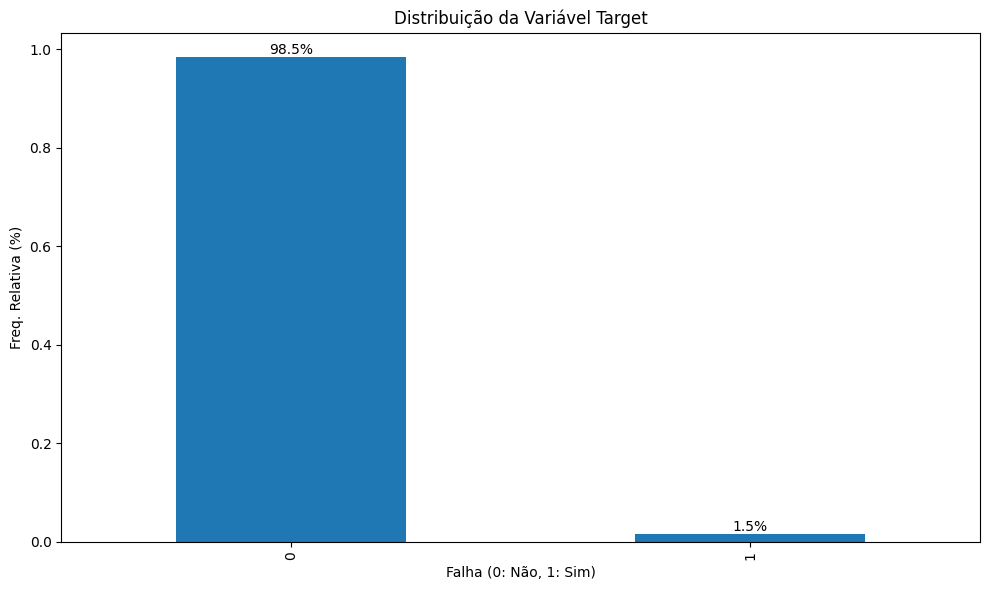

In [9]:
# Distribuição da Variável Target
plt.figure(figsize=(10, 6))
ax = df['falha_maquina'].value_counts(normalize=True).plot(kind='bar', title='Distribuição da Variável Target')

# Adiciona rótulos nas barras
for i, v in enumerate(df['falha_maquina'].value_counts(normalize=True)):
    ax.text(i, v, f'{v:.1%}', ha='center', va='bottom')

plt.xlabel('Falha (0: Não, 1: Sim)')
plt.ylabel('Freq. Relativa (%)')

if df['falha_maquina'].value_counts(normalize=True)[1] < 0.1:
    print("Variável Alvo Desbalanceada, classe=1 (falha) abaixo de 10%")
else:
    print("Variável Alvo Não Desbalanceada")

plt.tight_layout()

**Comentários**:
- A variável alvo `falha_maquina` esta altamente desbalanceada, havendo poucos registros de falhas.
- Desta forma, vamos separar um dataframe somente para os casos de falha.

In [10]:
# Criar um dataframe com falhas e sem falhas
df_falhas = df[df['falha_maquina'] == 1]

df_falhas['tipo_falha'].value_counts(normalize=True) *100

tipo_falha
Dissipação de Calor       40.582524
Tensão Excessiva          26.796117
Sem falhas                15.145631
Desgaste da Ferramenta    11.456311
Falha de Potência          5.825243
Falha Aleatória            0.194175
Name: proportion, dtype: float64

**Obs.:** É possível vê que mesmo após realizar o subset (apenas com falha_maquina=1), ainda assim há dados como "sem falhas". Vamos remover estes dados.

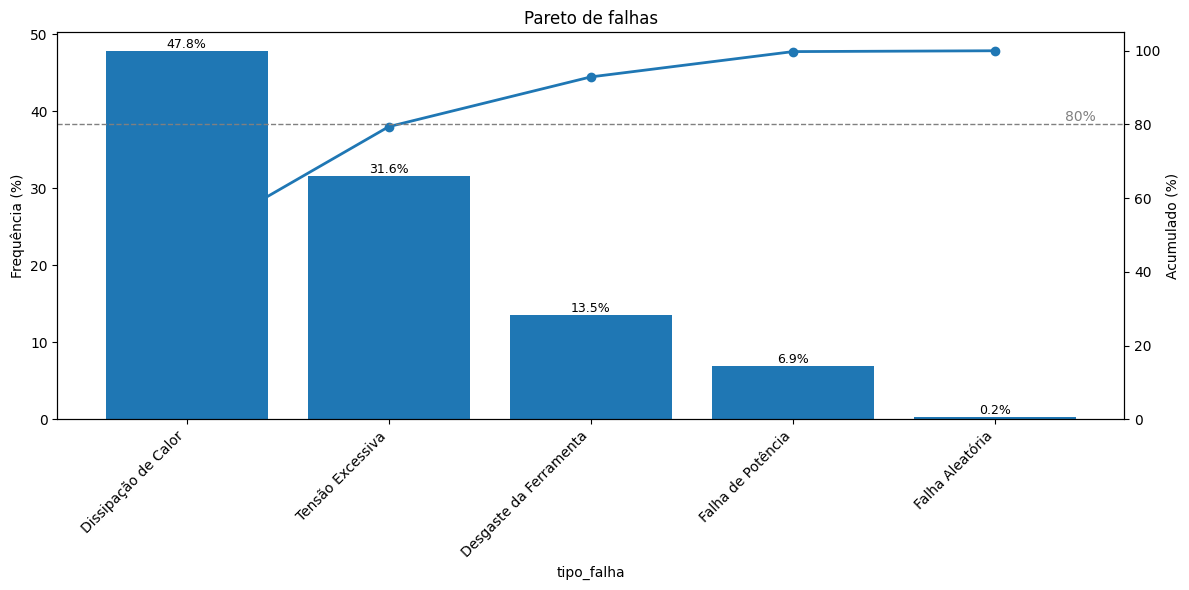

(tipo_falha
 Dissipação de Calor       47.826087
 Tensão Excessiva          31.578947
 Desgaste da Ferramenta    13.501144
 Falha de Potência          6.864989
 Falha Aleatória            0.228833
 Name: proportion, dtype: float64,
 tipo_falha
 Dissipação de Calor        47.826087
 Tensão Excessiva           79.405034
 Desgaste da Ferramenta     92.906178
 Falha de Potência          99.771167
 Falha Aleatória           100.000000
 Name: proportion, dtype: float64)

In [11]:
df_falhas = df_falhas[df_falhas['tipo_falha'] != 'Sem falhas']

# Plotar o gráfico de Pareto
plot_pareto(df_falhas, col='tipo_falha', normalize=True, cutoff=0.80, rotate_xticks=45, title='Pareto de falhas')

In [12]:
df_falhas_tipo = df_falhas.groupby('tipo_falha')['tipo'].value_counts().reset_index()
df_falhas_tipo['% de Falhas'] = round(df_falhas_tipo['count'] / df_falhas_tipo['count'].sum() * 100, 2)
df_falhas_tipo.sort_values(by='% de Falhas', ascending=False, inplace=True)
df_falhas_tipo

,tipo_falha,tipo,count,% de Falhas
3,Dissipação de Calor,Baixa,136,31.12
10,Tensão Excessiva,Baixa,132,30.21
4,Dissipação de Calor,Média,57,13.04
0,Desgaste da Ferramenta,Baixa,41,9.38
7,Falha de Potência,Baixa,18,4.12
1,Desgaste da Ferramenta,Média,16,3.66
5,Dissipação de Calor,Alta,16,3.66
8,Falha de Potência,Média,11,2.52
11,Tensão Excessiva,Média,4,0.92
2,Desgaste da Ferramenta,Alta,2,0.46


#### Variável Tipo

Text(0, 0.5, 'Freq. Relativa (%)')

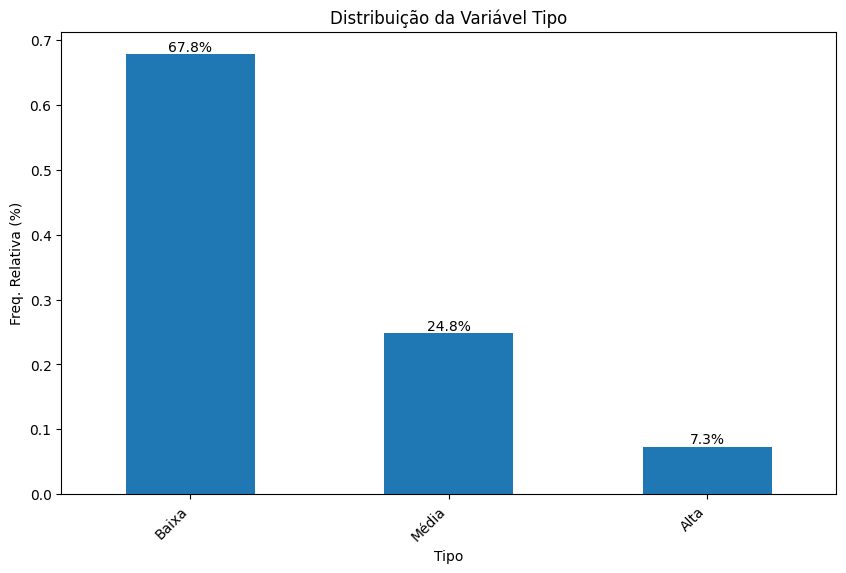

In [13]:
# Distribuição da Variável Target
plt.figure(figsize=(10, 6))
ax = df['tipo'].value_counts(normalize=True).plot(kind='bar', title='Distribuição da Variável Tipo')

# Adiciona rótulos nas barras
for i, v in enumerate(df['tipo'].value_counts(normalize=True)):
    ax.text(i, v, f'{v:.1%}', ha='center', va='bottom')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.xlabel('Tipo')
plt.ylabel('Freq. Relativa (%)')

<Axes: xlabel='tipo_falha', ylabel='count'>

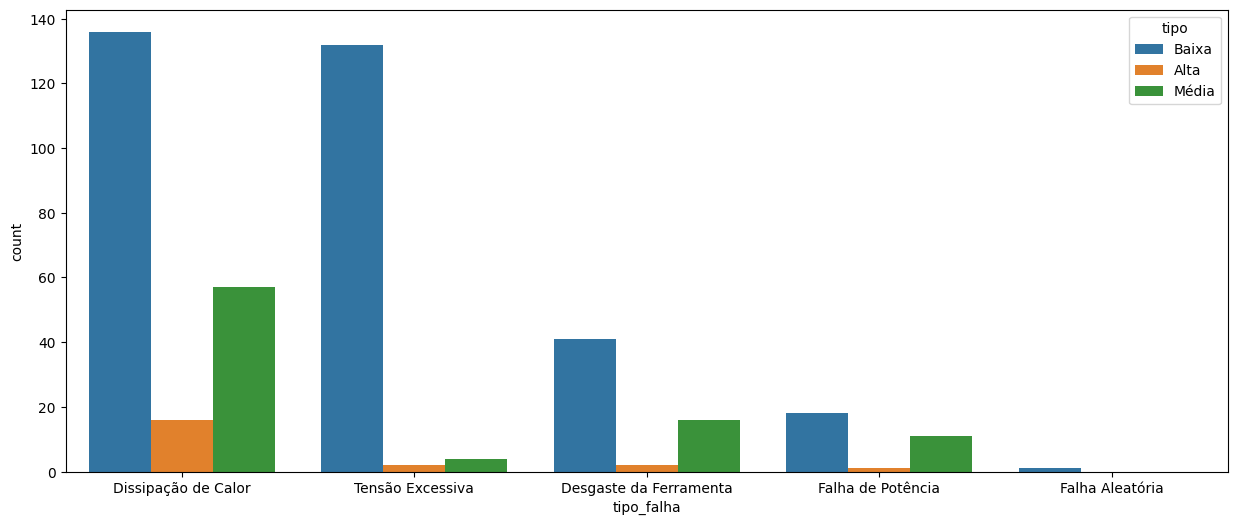

In [14]:
# Criar um gráfico pareto para a variável 'tipo_falha'
plt.figure(figsize=(15, 6))
sns.countplot(x='tipo_falha', data=df_falhas, hue='tipo', order=df_falhas['tipo_falha'].value_counts().index)

In [ ]:
# Criar um dataframe com falhas e sem falhas
df_falhas = df[df['falha_maquina'] == 1]

df_falhas_tipo = df_falhas.groupby('tipo')['tipo_falha'].value_counts().reset_index()
df_falhas_tipo['% de Falhas'] = round(df_falhas_tipo['count'] / df_falhas_tipo['count'].sum() * 100, 2)
df_falhas_tipo.sort_values(by='% de Falhas', ascending=False, inplace=True)
df_falhas_tipo

In [ ]:
# Criar um gráfico pareto para a variável 'tipo_falha'
plt.figure(figsize=(15, 6))
sns.countplot(x='tipo_falha', data=df_falhas, hue='tipo', order=df_falhas['tipo_falha'].value_counts().index)
plt.show()



In [ ]:
# Criar um gráfico pareto para a variável 'tipo_falha'
plt.figure(figsize=(15, 6))
sns.countplot(x='tipo_falha', data=df_falhas, hue='tipo', order=df_falhas['tipo_falha'].value_counts().index)
plt.show()

In [ ]:
# Plot bar graphic
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df_falhas, x='tipo_falha')
plt.title('Proportion of Failures')
plt.xlabel('Type')
plt.ylabel('Count')

ax = sns.countplot(data=df_falhas, x = 'tipo_falha')

# Add as percentages as labels
total = len(df_falhas['tipo_falha'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

In [ ]:
plot_distribution_and_boxplot_hue_safe(df_falhas, numeric_cols, hue_col='tipo')